In [86]:
import os
import numpy as np
import pandas as pd
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
from numpy import *
from sklearn import *
from PSO_IBK import *
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import pickle
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import time
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter
from sklearn.gaussian_process.kernels import RBF

In [87]:
#Celgene
AscVen_whole = pd.read_csv('AscVen_AI.csv')
Celgene_whole = pd.read_csv ('Celgene_AI.csv')

In [88]:
#Split X and Y
#Celgene

AscVen= AscVen_whole.drop('DISCONT',axis=1)
AVY = AscVen_whole['DISCONT']

Celgene= Celgene_whole.drop('DISCONT',axis=1)
CELY = Celgene_whole['DISCONT']

In [89]:
#Separate columns for encoding and scaling

#Scale
AscVen_to_scale = AscVen.select_dtypes(exclude = 'object')
Celgene_to_scale = Celgene.select_dtypes(exclude = 'object')

#Encode
AscVen_to_encode = AscVen.select_dtypes('object')
Celgene_to_encode = Celgene.select_dtypes('object')

In [90]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
enc    = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [91]:
#Scale
AscVen_scale_columns_names = []
for col in AscVen_to_scale.columns: 
    AscVen_scale_columns_names.append(col)
Celgene_scale_columns_names = []
for col in Celgene_to_scale.columns: 
    Celgene_scale_columns_names.append(col)
    
#Encode    
AscVen_encode_columns_names = []
for col in AscVen_to_encode.columns: 
    AscVen_encode_columns_names.append(col)
Celgene_encode_columns_names = []
for col in Celgene_to_encode.columns: 
    Celgene_encode_columns_names.append(col)

In [92]:
# Scale and Encode Separate Columns
#Scale
scaler.fit(AscVen[AscVen_scale_columns_names]) 
AscVen_scaled_columns  = scaler.transform(AscVen[AscVen_scale_columns_names])
Celgene_scaled_columns  = scaler.transform(Celgene[Celgene_scale_columns_names])

#Encode
enc.fit(AscVen[AscVen_encode_columns_names])
AscVen_encoded_columns = enc.transform((AscVen[AscVen_encode_columns_names]))
Celgene_encoded_columns = enc.transform(Celgene[Celgene_encode_columns_names])

In [93]:
# Concatenate (Column-Bind) Processed Columns Back Together
#Train
New_AscVen = np.concatenate([AscVen_scaled_columns,AscVen_encoded_columns], axis=1)

#Test
New_Celgene = np.concatenate([Celgene_scaled_columns,Celgene_encoded_columns], axis=1)

In [94]:
print(New_AscVen.shape, New_Celgene.shape)

(1074, 94) (526, 94)


In [95]:
KPCA = decomposition.KernelPCA(kernel= 'rbf', n_components=50) 

KPCA.fit(New_AscVen)
AscVen = KPCA.transform(New_AscVen)
Celgene = KPCA.transform(New_Celgene)

In [96]:
#Before SMOTE
Ccounter = Counter(AVY)

print(Ccounter)

Counter({0: 918, 1: 156})


In [97]:
#After SMOTE
from collections import Counter
sm =  SVMSMOTE(random_state = 42)

AscVen, AVY = sm.fit_resample(AscVen, AVY)

Ccounter = Counter(AVY)

print(Ccounter)

Counter({0: 918, 1: 918})


In [98]:
#Train
AVX = np.array(AscVen)
AVY = np.array(AVY)

#Test
CEL = np.array(Celgene)
CELY = np.array(CELY)

In [99]:
AVY = np.array(pd.Categorical(AVY))
CELY = np.array(pd.Categorical(CELY))

AVY = np.array(AVY.astype(int))
CELY = np.array(CELY.astype(int))

In [81]:
parameter = {'n_estimators': [500], 'max_depth': [4], 'ccp_alpha':[0.0], 'max_features': ['auto'], 'random_state': [42]}
cRF = model_selection.GridSearchCV(ensemble.RandomForestClassifier(),parameter, cv=5, n_jobs=-1)

cRF.fit(AVX, AVY)
RCmodel = cRF.predict_proba(CEL)    
RCauc  = metrics.roc_auc_score(CELY, RCmodel[:,1])
RCfpr, RCtpr, RCthresholds = metrics.roc_curve(CELY, RCmodel[:,1])
RCauprc  = metrics.average_precision_score(CELY, RCmodel[:,1])
RCr, RCp, RCthresholds1 = metrics.precision_recall_curve(CELY, RCmodel[:,1])
    
print('AUC: ', RCauc, 'AUPRC: ', RCauprc)
print(cRF.best_params_)

AUC:  0.6478752828765402 AUPRC:  0.15275604463701464
{'ccp_alpha': 0.0, 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500, 'random_state': 42}


In [60]:
parameter = {'n_estimators': [500], 'max_depth': [2], 'learning_rate':[0.01], 'random_state': [42]}
cLGB = model_selection.GridSearchCV(lgb.LGBMClassifier(),parameter, cv=5, n_jobs=-1)
cLGB.fit(AVX, AVY)

LCmodel = cLGB.predict_proba(CEL)    
LCauc  = metrics.roc_auc_score(CELY, LCmodel[:,1])
LCfpr, LCtpr, LCthresholds = metrics.roc_curve(CELY, LCmodel[:,1])
LCauprc  = metrics.average_precision_score(CELY, LCmodel[:,1])
LCr, LCp, LCthresholds1 = metrics.precision_recall_curve(CELY, LCmodel[:,1])
    
print('AUC: ', LCauc, 'AUPRC: ', LCauprc)
print(cLGB.best_params_)

AUC:  0.6457379934624089 AUPRC:  0.1463013949879687
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'random_state': 42}


In [65]:
parameter = {'n_estimators': [100], 'max_depth': [4], 'learning_rate':[0.01], 'random_state': [42]}
cXGB = model_selection.GridSearchCV(xgb.XGBClassifier(),parameter, cv=5, n_jobs=-1)
cXGB.fit(AVX, AVY)

XCmodel = cXGB.predict_proba(CEL)    
XCauc  = metrics.roc_auc_score(CELY, XCmodel[:,1])
XCfpr, XCtpr, XCthresholds = metrics.roc_curve(CELY, XCmodel[:,1])
XCauprc  = metrics.average_precision_score(CELY, XCmodel[:,1])
XCr, XCp, XCthresholds1 = metrics.precision_recall_curve(CELY, XCmodel[:,1])
    
print('AUC: ', XCauc, 'AUPRC: ', XCauprc)
print(cXGB.best_params_)

AUC:  0.6409102338446064 AUPRC:  0.12017641531517391
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}


In [68]:
parameter = {'n_estimators': [100], 'max_depth': [4], 'learning_rate':[0.01], 'random_state':[42]}
cCB = model_selection.GridSearchCV(cb.CatBoostClassifier(),parameter, cv=5, n_jobs=-1)
cCB.fit(AVX, AVY)
CCmodel = cCB.predict_proba(CEL)   
    
CCauc  = metrics.roc_auc_score(CELY, CCmodel[:,1])
CCfpr, CCtpr, CCthresholds = metrics.roc_curve(CELY, CCmodel[:,1])
CCauprc  = metrics.average_precision_score(CELY, CCmodel[:,1])
CCr, CCp, CCthresholds1 = metrics.precision_recall_curve(CELY, CCmodel[:,1])
    
print('AUC: ', CCauc, 'AUPRC: ', CCauprc)
print(cCB.best_params_)

0:	learn: 0.6889884	total: 6.1ms	remaining: 604ms
1:	learn: 0.6843058	total: 8.98ms	remaining: 440ms
2:	learn: 0.6801427	total: 12.1ms	remaining: 392ms
3:	learn: 0.6763406	total: 15ms	remaining: 360ms
4:	learn: 0.6726858	total: 17.8ms	remaining: 339ms
5:	learn: 0.6684192	total: 20.6ms	remaining: 322ms
6:	learn: 0.6643458	total: 23.3ms	remaining: 310ms
7:	learn: 0.6605676	total: 26.2ms	remaining: 301ms
8:	learn: 0.6568281	total: 28.9ms	remaining: 292ms
9:	learn: 0.6535535	total: 31.4ms	remaining: 283ms
10:	learn: 0.6496630	total: 35.4ms	remaining: 286ms
11:	learn: 0.6462308	total: 39.5ms	remaining: 290ms
12:	learn: 0.6424973	total: 42.8ms	remaining: 286ms
13:	learn: 0.6385262	total: 45.9ms	remaining: 282ms
14:	learn: 0.6349285	total: 49.1ms	remaining: 278ms
15:	learn: 0.6313815	total: 52.7ms	remaining: 276ms
16:	learn: 0.6282482	total: 55.9ms	remaining: 273ms
17:	learn: 0.6243030	total: 59ms	remaining: 269ms
18:	learn: 0.6214322	total: 62.3ms	remaining: 266ms
19:	learn: 0.6185627	total:

In [22]:
from sklearn.gaussian_process.kernels import RBF

In [70]:
parameter = {'n_neighbors': [5], 'weights': ['uniform'], 'algorithm':['auto']}
cKNN = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(),parameter, cv=5, n_jobs=-1)
cKNN.fit(AVX, AVY)
KCmodel = cKNN.predict_proba(CEL)   
    
KCauc  = metrics.roc_auc_score(CELY, KCmodel[:,1])
KCfpr, KCtpr, KCthresholds = metrics.roc_curve(CELY, KCmodel[:,1])
KCauprc  = metrics.average_precision_score(CELY, KCmodel[:,1])
KCr, KCp, KCthresholds1 = metrics.precision_recall_curve(CELY, KCmodel[:,1])
    
print('AUC: ', KCauc, 'AUPRC: ', KCauprc)
print(cKNN.best_params_)

AUC:  0.6761880814684436 AUPRC:  0.13686021098132728
{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}


In [100]:
opt = "PSO"

In [20]:
def optimizer(obj_func, initial_theta, bounds):
    
    if opt == "CMA-ES":
        initial_theta = initial_theta.tolist()
        xopts, es = cma.fmin(obj_func, initial_theta, sigma0=0.01, restarts=1)
        theta_opt = xopts
        func_min = es.fopt

    elif opt == "PSO":
        # model = PSO(obj_func, initial_theta, bounds, num_particles=15, maxiter=30)
        # theta_opt, func_min = model.optimize()

        model = PSO()
        theta_opt, func_min = model.optimize(
            obj_func, initial_theta, bounds, num_particles=100, maxiter=30)

    elif opt == "COBYLA" or "SLSQP" or "Nelder-Mead" or "Powell" or "BFGS" or "L-BFGS-B" or "TNC":
        # initial_theta = initial_theta.tolist()
        res = minimize(obj_func, initial_theta,
                       method=opt, jac=True, bounds=bounds)
        theta_opt = res.x
        func_min = res.fun

    return theta_opt, func_min

In [24]:
parameter = {'n_restarts_optimizer': [0], 'max_iter_predict': [100], 
             'warm_start':[False], 'multi_class':['one_vs_rest'], 'random_state': [42]}
cGPC1 = model_selection.GridSearchCV(gaussian_process.GaussianProcessClassifier(kernel=Kernel, optimizer=optimizer),
                                    parameter, cv=5, n_jobs=-1)
cGPC1.fit(AVX, AVY)
GCmodel1 = cGPC1.predict_proba(CEL)   
    
GCauc1  = metrics.roc_auc_score(CELY, GCmodel1[:,1])
GCfpr1, GCtpr1, GCthresholds2 = metrics.roc_curve(CELY, GCmodel1[:,1])
GCauprc1  = metrics.average_precision_score(CELY, GCmodel1[:,1])
GCr1, GCp1, GCthresholds11 = metrics.precision_recall_curve(CELY, GCmodel1[:,1])
    
print('AUC: ', GCauc1, 'AUPRC: ', GCauprc1)
print(cGPC1.best_params_)

###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### error ########
917.7370613201988
##############
###### err

###### error ########
942.1534298118032
##############
###### error ########
838.9754384925759
##############
###### error ########
1000.7855459843894
##############
###### error ########
886.4321913841089
##############
###### error ########
982.2884984031532
##############
###### error ########
939.1824651031789
##############
###### error ########
1038.0362351338683
##############
###### error ########
957.0533167681841
##############
###### error ########
969.5522705842961
##############
###### error ########
957.4824579649313
##############
###### error ########
857.3431943477715
##############
###### error ########
843.9704018559826
##############
###### error ########
922.5667404884931
##############
###### error ########
879.3428392574464
##############
###### error ########
1003.8764765444494
##############
###### error ########
845.9348131100271
##############
###### error ########
851.3525171330492
##############
###### error ########
933.3667913758029
##############
###### 

###### error ########
685.5901395309777
##############
###### error ########
753.5212329688077
##############
###### error ########
690.9006556575231
##############
###### error ########
717.0780869932796
##############
###### error ########
718.8879634615029
##############
###### error ########
915.556035138003
##############
###### error ########
704.7716155925232
##############
###### error ########
705.3357582512396
##############
###### error ########
682.5037280570342
##############
###### error ########
679.7703203772842
##############
###### error ########
869.4620484926727
##############
###### error ########
684.7463455281563
##############
###### error ########
789.8314066325713
##############
###### error ########
815.1540924677813
##############
###### error ########
777.862752950715
##############
###### error ########
671.408689316353
##############
###### error ########
737.6406749648656
##############
###### error ########
724.3350821263919
##############
###### error 

###### error ########
563.3420497712023
##############
###### error ########
622.464290869103
##############
###### error ########
690.5576621518874
##############
###### error ########
565.5739775993967
##############
###### error ########
735.2628045029631
##############
###### error ########
690.9316796407669
##############
###### error ########
636.3786668645288
##############
###### error ########
600.1884521617612
##############
###### error ########
628.1059600222098
##############
###### error ########
652.2706267889464
##############
###### error ########
587.9055846910205
##############
###### error ########
594.9496831007764
##############
###### error ########
709.6765528430115
##############
###### error ########
613.8999296873328
##############
###### error ########
793.4553655279385
##############
###### error ########
625.6974677600285
##############
###### error ########
630.316023797169
##############
###### error ########
602.2256442511343
##############
###### error

###### error ########
687.2272455182017
##############
###### error ########
527.8557996524867
##############
###### error ########
516.8405607601816
##############
###### error ########
514.3951360121624
##############
###### error ########
659.7033047368947
##############
###### error ########
514.3624683651867
##############
###### error ########
525.0750806749949
##############
###### error ########
536.1273005487537
##############
###### error ########
510.9660105857239
##############
###### error ########
581.8417065252252
##############
###### error ########
514.617677780833
##############
###### error ########
522.3309818929531
##############
###### error ########
519.9048720007802
##############
###### error ########
514.3025118908702
##############
###### error ########
614.5150115859459
##############
###### error ########
545.1938040073774
##############
###### error ########
510.7149980032598
##############
###### error ########
524.8806370541475
##############
###### erro

###### error ########
519.0109846672931
##############
###### error ########
517.6218094204014
##############
###### error ########
515.4014925665944
##############
###### error ########
519.0359829268265
##############
###### error ########
555.9347465088326
##############
###### error ########
548.85726186241
##############
###### error ########
517.8535307976066
##############
###### error ########
516.8525996698955
##############
###### error ########
513.2186813144084
##############
###### error ########
519.9258146422461
##############
###### error ########
512.2769159171135
##############
###### error ########
515.0654888658029
##############
###### error ########
514.1410041936233
##############
###### error ########
515.2849255809075
##############
###### error ########
546.1923232397198
##############
###### error ########
513.1157319825525
##############
###### error ########
515.6140927949186
##############
###### error ########
517.0929072078507
##############
###### error

###### error ########
559.8519912546093
##############
###### error ########
603.9940830320959
##############
###### error ########
524.5375355392996
##############
###### error ########
513.5342974192531
##############
###### error ########
511.87970608452133
##############
###### error ########
571.9546700695445
##############
###### error ########
512.0159979312807
##############
###### error ########
528.0782325493421
##############
###### error ########
524.9527739218055
##############
###### error ########
510.8466757555219
##############
###### error ########
618.2159181130886
##############
###### error ########
514.2248335919562
##############
###### error ########
514.116501897971
##############
###### error ########
512.65523535732
##############
###### error ########
510.5667906070431
##############
###### error ########
579.088948095905
##############
###### error ########
521.960740598293
##############
###### error ########
511.4942944596619
##############
###### error #

###### error ########
514.315517177448
##############
###### error ########
520.432118759501
##############
###### error ########
524.4820371786537
##############
###### error ########
510.4362958587056
##############
###### error ########
513.5905687811478
##############
###### error ########
533.4222797385437
##############
###### error ########
512.2530891539491
##############
###### error ########
510.83658088328855
##############
###### error ########
526.7694329310332
##############
###### error ########
510.4896845376044
##############
###### error ########
512.0138610971725
##############
###### error ########
535.1360685712286
##############
###### error ########
512.988973796594
##############
###### error ########
520.3373521015856
##############
###### error ########
512.0610743613908
##############
###### error ########
511.97911898999337
##############
###### error ########
512.533721325703
##############
###### error ########
511.6693045271304
##############
###### error

###### error ########
511.3846958471098
##############
###### error ########
510.5955657439183
##############
###### error ########
510.7738850905674
##############
###### error ########
512.0053789633544
##############
###### error ########
511.5054848666341
##############
###### error ########
510.4407689386828
##############
###### error ########
510.7766780470784
##############
###### error ########
545.9907169707708
##############
###### error ########
511.1030067545372
##############
###### error ########
510.94395544382934
##############
###### error ########
512.2195069142542
##############
###### error ########
510.40431022604116
##############
###### error ########
511.7554329883885
##############
###### error ########
510.7805982473606
##############
###### error ########
515.2134795939452
##############
###### error ########
518.1239802965331
##############
###### error ########
510.4281989566268
##############
###### error ########
514.9543496962983
##############
###### e

###### error ########
510.8793185323054
##############
###### error ########
511.20697025364314
##############
###### error ########
514.4238016539105
##############
###### error ########
511.0276241406741
##############
###### error ########
514.8776947516291
##############
###### error ########
510.4068300076913
##############
###### error ########
510.7140592799052
##############
###### error ########
512.7275979764504
##############
###### error ########
511.0529968804678
##############
###### error ########
510.39651998092813
##############
###### error ########
510.60341707752525
##############
###### error ########
510.7673505638726
##############
###### error ########
510.65973345707596
##############
###### error ########
561.6027244658798
##############
###### error ########
510.35961179929245
##############
###### error ########
518.2992280714735
##############
###### error ########
511.76052716140316
##############
###### error ########
510.5673316190321
##############
####

###### error ########
510.8353011790506
##############
###### error ########
510.7540878062411
##############
###### error ########
511.3110340405163
##############
###### error ########
510.492779974452
##############
###### error ########
513.8624864515251
##############
###### error ########
511.88024861316165
##############
###### error ########
510.4958802281657
##############
###### error ########
510.3695800703958
##############
###### error ########
511.75274851950326
##############
###### error ########
517.3698184657651
##############
###### error ########
510.5020391697685
##############
###### error ########
511.21672777355917
##############
###### error ########
511.40080794618206
##############
###### error ########
510.39750595168533
##############
###### error ########
513.258067631605
##############
###### error ########
510.6241252936753
##############
###### error ########
510.65902516219813
##############
###### error ########
510.41687999624486
##############
#####

###### error ########
510.5691501551417
##############
###### error ########
510.3793351884325
##############
###### error ########
511.0229107651234
##############
###### error ########
510.8789598209883
##############
###### error ########
513.0609755563858
##############
###### error ########
510.5546866224415
##############
###### error ########
511.1094397286764
##############
###### error ########
510.36713671749544
##############
###### error ########
510.3712195726009
##############
###### error ########
511.36657503798176
##############
###### error ########
510.3732723505093
##############
###### error ########
510.4150729437014
##############
###### error ########
510.70865715731
##############
###### error ########
510.4934473454566
##############
###### error ########
510.4095351269544
##############
###### error ########
515.5340923437451
##############
###### error ########
510.4801103185853
##############
###### error ########
510.4192525511984
##############
###### err

###### error ########
510.5159051286232
##############
###### error ########
510.48534223053025
##############
###### error ########
510.51303979012715
##############
###### error ########
510.5299584689361
##############
###### error ########
513.4198659422553
##############
###### error ########
510.37048457968046
##############
###### error ########
511.0249825651571
##############
###### error ########
510.3687008550242
##############
###### error ########
510.5262979061012
##############
###### error ########
510.36524244654845
##############
###### error ########
511.2818414418245
##############
###### error ########
520.1767498563872
##############
###### error ########
510.3876949541806
##############
###### error ########
510.6563316426302
##############
###### error ########
513.9205220768897
##############
###### error ########
510.362236764598
##############
###### error ########
511.8465383032284
##############
###### error ########
510.3675941721113
##############
###### 

###### error ########
510.559972513734
##############
###### error ########
510.3589304698221
##############
###### error ########
510.81917108711497
##############
###### error ########
510.45873380070196
##############
###### error ########
510.4013371915763
##############
###### error ########
510.42174983643616
##############
###### error ########
512.550302237874
##############
###### error ########
510.3781927898255
##############
###### error ########
510.459397818407
##############
###### error ########
510.35753768302425
##############
###### error ########
510.35867085567975
##############
###### error ########
510.4742233846254
##############
###### error ########
510.4779923628794
##############
###### error ########
510.3591462195135
##############
###### error ########
510.36716253695215
##############
###### error ########
510.3859577941672
##############
###### error ########
510.37462120170164
##############
###### error ########
510.61205748128094
##############
#####

###### error ########
510.3753484624009
##############
###### error ########
510.3936260054113
##############
###### error ########
510.9420752812167
##############
###### error ########
510.51294849199223
##############
###### error ########
510.3596137701827
##############
###### error ########
510.3902723496158
##############
###### error ########
510.5501545576627
##############
###### error ########
510.35824781819224
##############
###### error ########
512.5961921776005
##############
###### error ########
510.38505348716745
##############
###### error ########
510.37821815060903
##############
###### error ########
510.36066193164237
##############
###### error ########
510.3914203974616
##############
###### error ########
510.7062031999506
##############
###### error ########
510.359702409836
##############
###### error ########
510.5510053022352
##############
###### error ########
510.39409151052666
##############
###### error ########
510.36275710874224
##############
####

###### error ########
510.3574526048744
##############
###### error ########
510.40359239297067
##############
###### error ########
510.44479157937974
##############
###### error ########
510.3574395591771
##############
###### error ########
510.41627927565065
##############
###### error ########
510.3667824464021
##############
###### error ########
510.36694303061876
##############
###### error ########
510.37100159364854
##############
###### error ########
511.33132057942134
##############
###### error ########
510.35804099904726
##############
###### error ########
510.36075221868873
##############
###### error ########
510.35771757245396
##############
###### error ########
510.35919414048715
##############
###### error ########
510.3749306452479
##############
###### error ########
510.41515838768584
##############
###### error ########
510.35871352903996
##############
###### error ########
510.3834059228086
##############
###### error ########
510.358590637023
##############

###### error ########
510.35757823572555
##############
###### error ########
510.3724049508473
##############
###### error ########
510.35791870713655
##############
###### error ########
510.3582256052015
##############
###### error ########
510.398356173121
##############
###### error ########
510.5780544286009
##############
###### error ########
510.35805481840373
##############
###### error ########
510.36217714140486
##############
###### error ########
510.36196228230517
##############
###### error ########
510.7575768338929
##############
###### error ########
510.3576470877183
##############
###### error ########
510.53604065961406
##############
###### error ########
510.3769576392345
##############
###### error ########
510.3719561310277
##############
###### error ########
510.35799799412666
##############
###### error ########
510.36555099338375
##############
###### error ########
511.07811989238604
##############
###### error ########
510.3578790511401
##############
##

###### error ########
510.52525780063473
##############
###### error ########
510.50949732264564
##############
###### error ########
510.3579455577634
##############
###### error ########
510.35743970424903
##############
###### error ########
510.4661719242252
##############
###### error ########
510.3721363840862
##############
###### error ########
510.35754551371076
##############
###### error ########
510.3667456441186
##############
###### error ########
510.3610320960708
##############
###### error ########
510.3627554824325
##############
###### error ########
510.38939870869575
##############
###### error ########
510.3837528981926
##############
###### error ########
510.3576124231264
##############
###### error ########
510.3728507315027
##############
###### error ########
510.3575444999766
##############
###### error ########
510.35830644422316
##############
###### error ########
510.3998956542728
##############
###### error ########
510.42803415919957
##############
###

###### error ########
510.36903723173793
##############
###### error ########
510.36273015963945
##############
###### error ########
510.3583696799433
##############
###### error ########
510.3575686669619
##############
###### error ########
510.3577848870502
##############
###### error ########
510.3579359287762
##############
###### error ########
510.3606462955263
##############
###### error ########
510.3585000366196
##############
###### error ########
510.36888920984444
##############
###### error ########
510.3581829003289
##############
###### error ########
510.357556130689
##############
###### error ########
510.36185995086475
##############
###### error ########
510.38822304343586
##############
###### error ########
510.35743395884845
##############
###### error ########
510.3880283606381
##############
###### error ########
510.35922763678053
##############
###### error ########
510.35742451127163
##############
###### error ########
510.3574895517203
##############
###

###### error ########
510.3574279051303
##############
###### error ########
510.3600367007871
##############
###### error ########
510.3637156626842
##############
###### error ########
510.3583871452655
##############
###### error ########
510.44859767328234
##############
###### error ########
510.3611526898253
##############
###### error ########
510.36229220140723
##############
###### error ########
510.3574113026431
##############
###### error ########
510.368537309551
##############
###### error ########
510.3621287764527
##############
###### error ########
510.3574329616538
##############
###### error ########
510.36826602718963
##############
###### error ########
510.3579568348773
##############
###### error ########
510.35747288404434
##############
###### error ########
510.3644672561695
##############
###### error ########
510.5394871927509
##############
###### error ########
510.3574463009214
##############
###### error ########
510.37034233809766
##############
######

###### error ########
510.3574577362276
##############
###### error ########
510.35807779364114
##############
###### error ########
510.35742292538714
##############
###### error ########
510.35741636896597
##############
###### error ########
510.36216268003955
##############
###### error ########
510.3581661275047
##############
###### error ########
510.35759448562374
##############
###### error ########
510.35758463564116
##############
###### error ########
510.35754126729717
##############
###### error ########
510.3574161999547
##############
###### error ########
510.36322701397313
##############
###### error ########
510.35771289732565
##############
###### error ########
510.36774133966986
##############
###### error ########
510.3574266671262
##############
AUC:  0.6948453608247422 AUPRC:  0.2126069604533513
{'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_restarts_optimizer': 0, 'random_state': 42, 'warm_start': False}


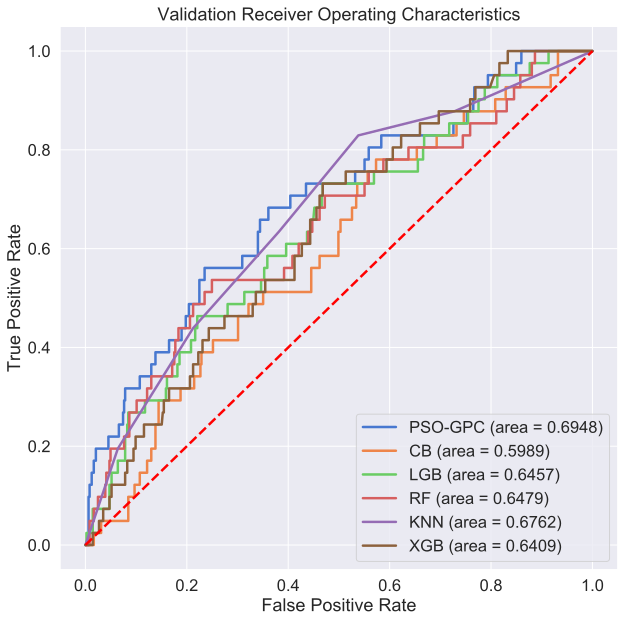

In [84]:
plt.figure(figsize=(10,10))
plt.plot(GCfpr1, GCtpr1, label = 'PSO-GPC (area = %0.4f)' % GCauc1)
plt.plot(CCfpr, CCtpr, label = 'CB (area = %0.4f)' % CCauc)
plt.plot(LCfpr, LCtpr, label = 'LGB (area = %0.4f)' % LCauc)
plt.plot(RCfpr, RCtpr, label = 'RF (area = %0.4f)' % RCauc)
plt.plot(KCfpr, KCtpr, label = 'KNN (area = %0.4f)' % KCauc)
plt.plot(XCfpr, XCtpr, label = 'XGB (area = %0.4f)' % XCauc)

plt.plot([0,1], [0,1], 'r--')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Receiver Operating Characteristics')
plt.legend(loc = 'lower right')
plt.savefig("ValidCELGENE_KPCA.png", format="png")
plt.show()

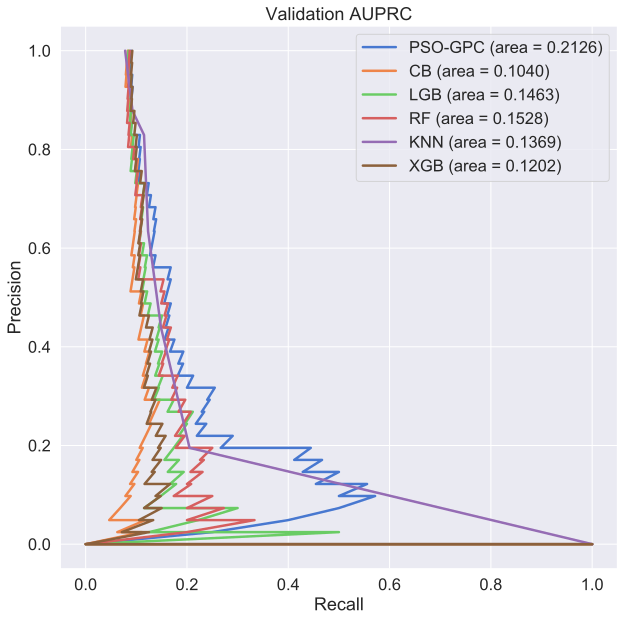

In [85]:
plt.figure(figsize=(10,10))
plt.plot(GCr1, GCp1, label = 'PSO-GPC (area = %0.4f)' % GCauprc1)
plt.plot(CCr, CCp, label = 'CB (area = %0.4f)' % CCauprc)
plt.plot(LCr, LCp, label = 'LGB (area = %0.4f)' % LCauprc)
plt.plot(RCr, RCp, label = 'RF (area = %0.4f)' % RCauprc)
plt.plot(KCr, KCp, label = 'KNN (area = %0.4f)' % KCauprc)
plt.plot(XCr, XCp, label = 'XGB (area = %0.4f)' % XCauprc)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Validation AUPRC')
plt.legend(loc = 'upper right')
plt.savefig("ValidCELGENE_KPCAuprc.png", format="png")
plt.show()